In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytz

In [2]:
# Set graphing rules
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)

Populating the interactive namespace from numpy and matplotlib


In [3]:
rome = pytz.timezone('Europe/Warsaw')
rome

<DstTzInfo 'Europe/Warsaw' LMT+1:24:00 STD>

In [4]:
# Import trainging data
rawTD = pd.read_csv('/Users/jcoleman/Google Drive/ResearchElective_2/Data/TrainingSet_RAW.csv')

In [5]:
# Import CO2 data from sensors
co2_RAW = pd.read_csv('/Users/jcoleman/Google Drive/ResearchElective_2/Data/CO2meanByMinute2.csv')

In [6]:
# Set Unix column to be index of DataFrame
# Drop non-pythonic datatypes
td = rawTD.set_index('Unix')
td.drop(['Date (Rome)', 'Time (Rome)','DateTime (Rome)','DateTime (Zulu)'], axis=1, inplace=True)
td['rome_time'] = pd.to_datetime(td.index, unit='s').tz_localize(pytz.utc).tz_convert(rome)
td['rome_hour'] = pd.to_datetime(td.index,unit='s').tz_localize(pytz.utc).tz_convert(rome).hour
td.head()

,# Occupants,Window Open,Door Open,rome_time,rome_hour
Unix,,,,,
1510688160,4,0,1,2017-11-14 20:36:00+01:00,20
1510699500,4,0,1,2017-11-14 23:45:00+01:00,23
1510704600,1,0,1,2017-11-15 01:10:00+01:00,1
1510761660,3,0,1,2017-11-15 17:01:00+01:00,17
1510763820,3,1,0,2017-11-15 17:37:00+01:00,17


In [7]:
# Set Time column to be index of DataFrame
co2 = co2_RAW.set_index('Time')
co2.columns = ['id','ppm']
co2.head()

,id,ppm
Time,,
1510534320,1,1005.125000
1510534920,1,1020.076923
1510534980,1,1011.600000
1510535220,1,1099.923077
1510535280,1,1033.250000


In [8]:
# Calculate local time in Rome for each sample
co2['rome_time'] = pd.to_datetime(co2.index, unit='s').tz_localize(pytz.utc).tz_convert(rome)
co2.head()

,id,ppm,rome_time
Time,,,
1510534320,1,1005.125000,2017-11-13 01:52:00+01:00
1510534920,1,1020.076923,2017-11-13 02:02:00+01:00
1510534980,1,1011.600000,2017-11-13 02:03:00+01:00
1510535220,1,1099.923077,2017-11-13 02:07:00+01:00
1510535280,1,1033.250000,2017-11-13 02:08:00+01:00


In [9]:
# Determine all the unique sensor IDs in the DataFrame
uniqueIDs = co2.id.unique()
print(uniqueIDs)

[1 2 3 4]


In [10]:
# Group CO2 data by sensor ID
indSensors = {}
for i in uniqueIDs:
    indSensors[str(i)] = co2.loc[co2.id == i]

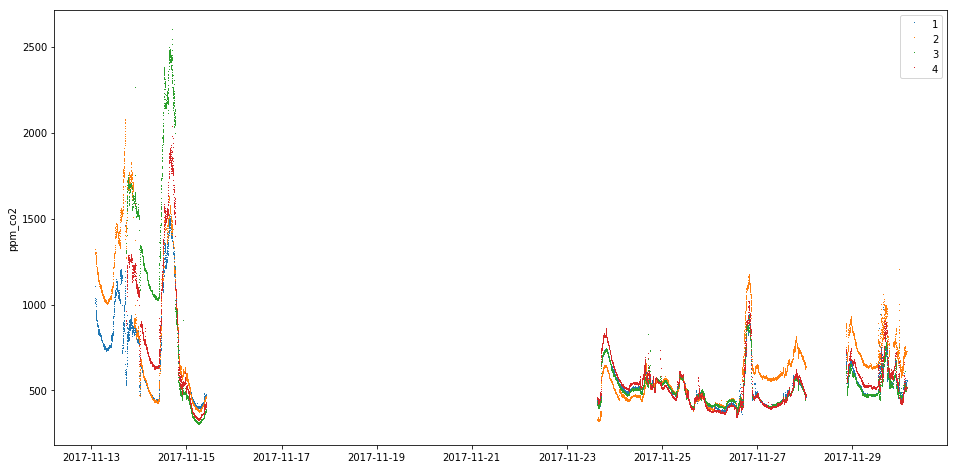

In [11]:
# Graph it...
# ...there's a hole in my data
numVals = 100000
for i in indSensors:
    x_dates = pd.to_datetime(indSensors[i].head(numVals).index, unit='s')
    plt.plot_date(x=indSensors[i].head(numVals).rome_time, y=indSensors[i].head(numVals).ppm, marker=',', label=i)
# plt.xlabel('DateTime')
plt.ylabel('ppm_co2')
plt.legend(loc='upper right')
plt.show()

In [12]:
# Find the CO2 values for each training sample
trainingset = []
for i in rawTD.Unix:
    row = []
    row.append(i)
    for j in indSensors:
        index = indSensors[j].index.searchsorted(i)
        row.append(indSensors[j].iloc[index]['ppm'])
    trainingset.append(row)

In [13]:
# Set unix time to be the index of the DataFrame
df = pd.DataFrame(trainingset)
# df.set_index(df[0], inplace=True)
x = ['unix']
x.extend(list(indSensors.keys()))
df.columns = x
df.set_index(df['unix'], inplace=True)
df.drop(['unix'], axis = 1, inplace = True)
df.shape

(75, 4)

In [14]:
# Appened the CO2 readings for each Training sampel
cleanedDataset = pd.concat([td, df], axis=1)
cleanedDataset.head()

,# Occupants,Window Open,Door Open,rome_time,rome_hour,1,2,3,4
1510688160,4,0,1,2017-11-14 20:36:00+01:00,20,612.375000,619.333333,516.875000,564.958333
1510699500,4,0,1,2017-11-14 23:45:00+01:00,23,531.555556,574.916667,450.500000,485.478261
1510704600,1,0,1,2017-11-15 01:10:00+01:00,1,531.555556,520.083333,437.250000,481.500000
1510761660,3,0,1,2017-11-15 17:01:00+01:00,17,434.200000,325.454545,425.909091,453.090909
1510763820,3,1,0,2017-11-15 17:37:00+01:00,17,434.200000,325.454545,425.909091,453.090909


In [15]:
# Use this to write out the DataFrame
# cleaned_dataset.to_csv('cleanedDataSet.csv')

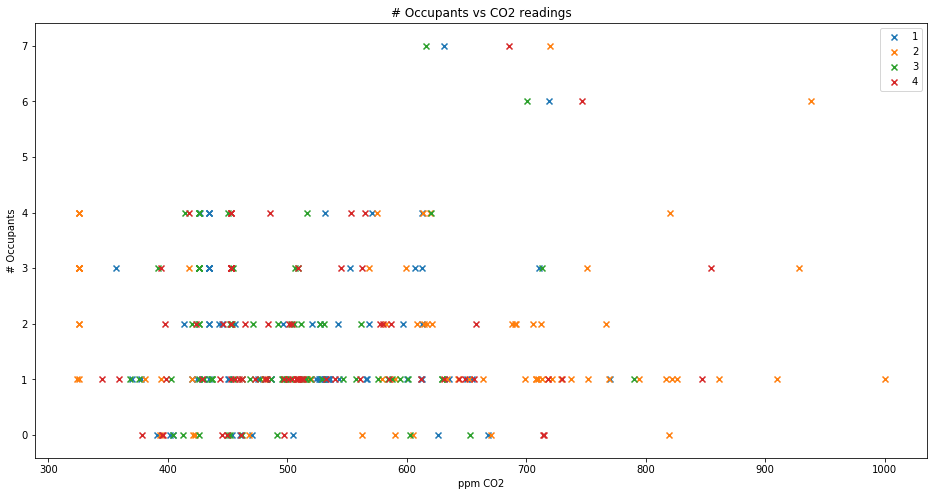

In [16]:
# Plot ppm CO2 vs occupancy
for _id in uniqueIDs:
    _id=str(_id)
    plt.scatter(y=cleanedDataset['# Occupants'], x=cleanedDataset[_id], marker='x', label=_id)
plt.ylabel('# Occupants')
plt.xlabel('ppm CO2')
plt.legend(loc='upper right')
plt.title('# Occupants vs CO2 readings')
plt.show()

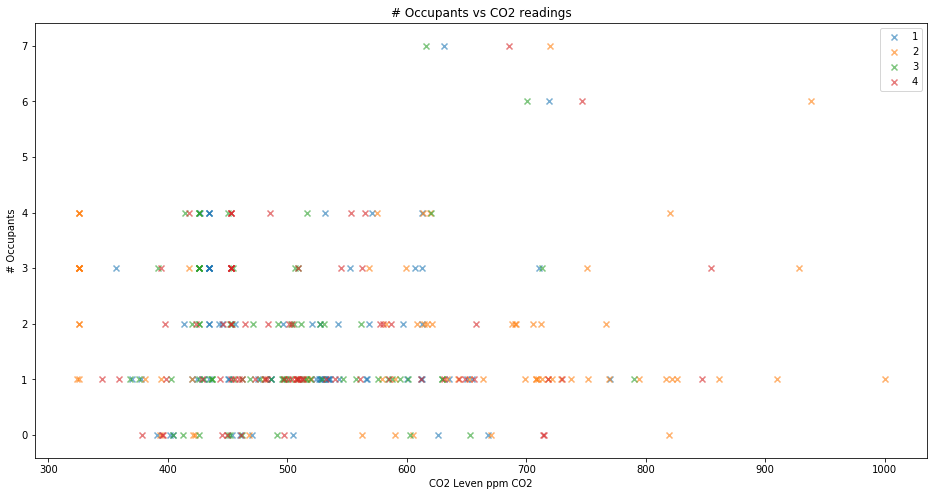

In [17]:
# Checking clarity of plot after affecting transparency of points
columnsToPlot = ['1','2','3','4']
for c in columnsToPlot:
    plt.scatter(y=cleanedDataset['# Occupants'], x=cleanedDataset[c], marker='x', label=c, alpha=0.6)
plt.ylabel('# Occupants')
plt.xlabel('CO2 Leven ppm CO2')
plt.legend(loc='upper right')
plt.title('# Occupants vs CO2 readings')
plt.show()

In [18]:
# Make a copy of the cleaned data and append the mean ppm CO2 reading
cleanedDatasetMean = cleanedDataset
cleanedDataset['_mean'] = cleanedDatasetMean[columnsToPlot].mean(axis=1)
cleanedDataset.head()

,# Occupants,Window Open,Door Open,rome_time,rome_hour,1,2,3,4,_mean
1510688160,4,0,1,2017-11-14 20:36:00+01:00,20,612.375000,619.333333,516.875000,564.958333,578.385417
1510699500,4,0,1,2017-11-14 23:45:00+01:00,23,531.555556,574.916667,450.500000,485.478261,510.612621
1510704600,1,0,1,2017-11-15 01:10:00+01:00,1,531.555556,520.083333,437.250000,481.500000,492.597222
1510761660,3,0,1,2017-11-15 17:01:00+01:00,17,434.200000,325.454545,425.909091,453.090909,409.663636
1510763820,3,1,0,2017-11-15 17:37:00+01:00,17,434.200000,325.454545,425.909091,453.090909,409.663636


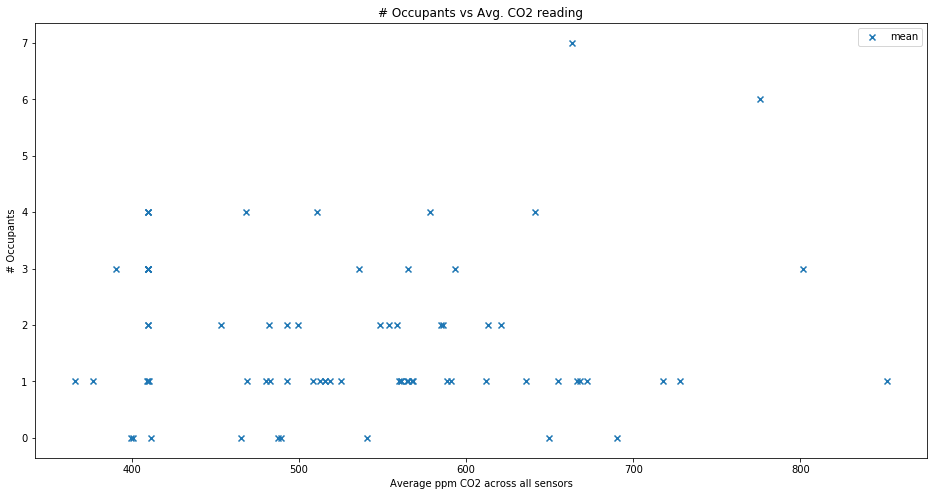

In [19]:
# Investigating the correlation of mean ppm co2 and occupancy
plt.scatter(y=cleanedDatasetMean['# Occupants'], x=cleanedDatasetMean['_mean'], marker='x', label='mean')
plt.ylabel('# Occupants')
plt.xlabel('Average ppm CO2 across all sensors')
plt.legend(loc='upper right')
plt.title('# Occupants vs Avg. CO2 reading')
plt.show()

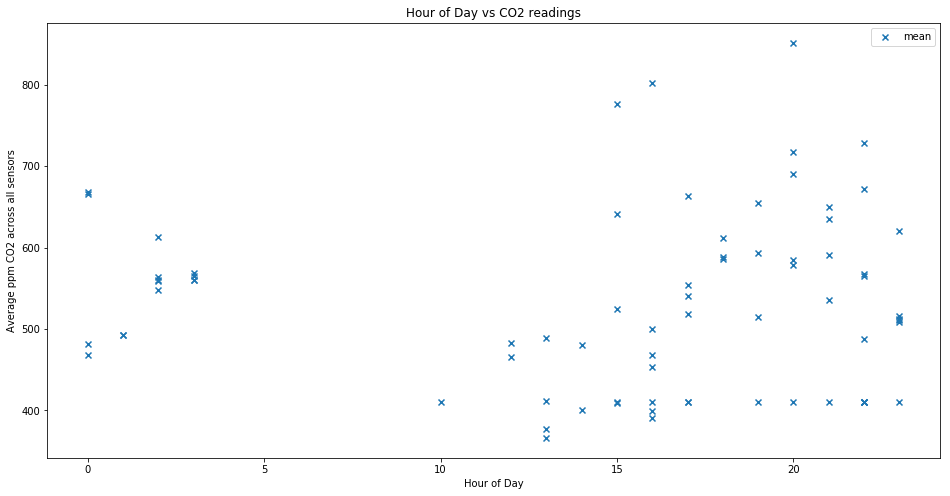

In [20]:
# Investigating the correlation of hour and occupancy
plt.scatter(x=cleanedDatasetMean['rome_hour'], y=cleanedDatasetMean['_mean'], marker='x', label='mean')
plt.xlabel('Hour of Day')
plt.ylabel('Average ppm CO2 across all sensors')
plt.legend(loc='upper right')
plt.title('Hour of Day vs CO2 readings')
plt.show()

In [21]:
# Use this to write out the DataFrame
# cleanedDatasetMean.to_csv('cleanedDataSet.csv')

In [22]:
booleanOccupancy = cleanedDatasetMean
booleanOccupancy['occupied'] = np.where(booleanOccupancy['# Occupants'] > 0, 1,0)
booleanOccupancy.head()

,# Occupants,Window Open,Door Open,rome_time,rome_hour,1,2,3,4,_mean,occupied
1510688160,4,0,1,2017-11-14 20:36:00+01:00,20,612.375000,619.333333,516.875000,564.958333,578.385417,1
1510699500,4,0,1,2017-11-14 23:45:00+01:00,23,531.555556,574.916667,450.500000,485.478261,510.612621,1
1510704600,1,0,1,2017-11-15 01:10:00+01:00,1,531.555556,520.083333,437.250000,481.500000,492.597222,1
1510761660,3,0,1,2017-11-15 17:01:00+01:00,17,434.200000,325.454545,425.909091,453.090909,409.663636,1
1510763820,3,1,0,2017-11-15 17:37:00+01:00,17,434.200000,325.454545,425.909091,453.090909,409.663636,1


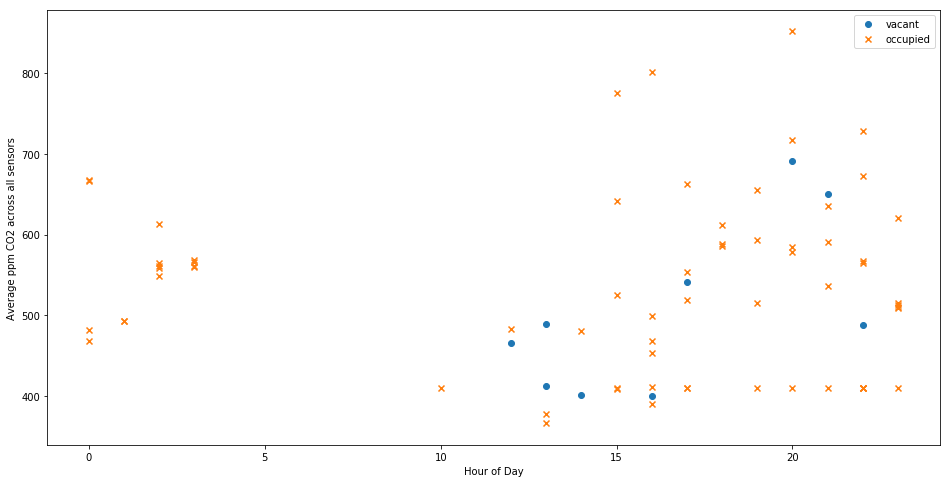

In [23]:
# Investigating the correlation of mean_ppm and occupancy

room_empty = booleanOccupancy[['rome_hour', '_mean']].loc[booleanOccupancy['occupied'] == 0]
room_occupied = booleanOccupancy[['rome_hour', '_mean']].loc[booleanOccupancy['occupied'] > 0]

plt.scatter(x=room_empty['rome_hour'], y=room_empty['_mean'], marker='o', label='vacant')
plt.scatter(x=room_occupied['rome_hour'], y=room_occupied['_mean'], marker='x', label='occupied')
plt.xlabel('Hour of Day')
plt.ylabel('Average ppm CO2 across all sensors')
plt.legend(loc='upper right')
plt.show()

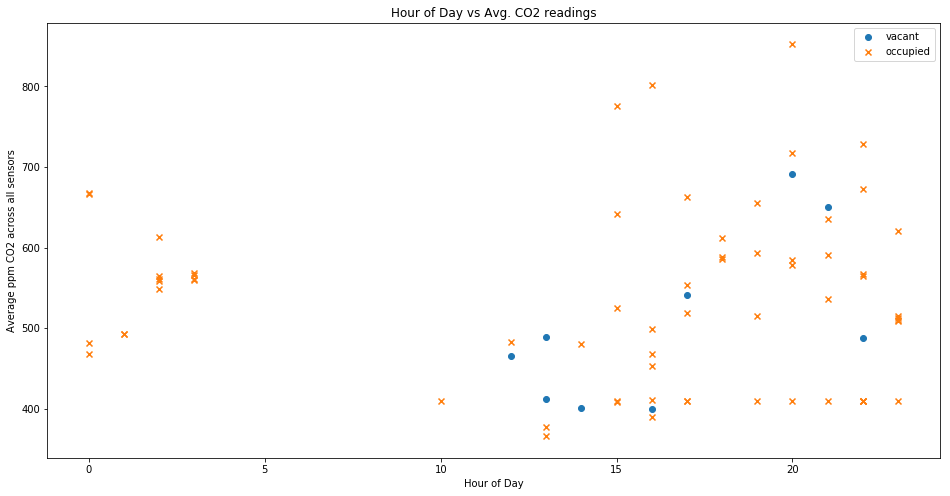

In [24]:
# Investigating the correlation of mean_ppm and window state

room_empty = booleanOccupancy[['rome_hour', '_mean']].loc[booleanOccupancy['# Occupants'] < 1]
room_occupied = booleanOccupancy[['rome_hour', '_mean']].loc[booleanOccupancy['# Occupants'] >= 1]

plt.scatter(x=room_empty['rome_hour'], y=room_empty['_mean'], marker='o', label='vacant')
plt.scatter(x=room_occupied['rome_hour'], y=room_occupied['_mean'], marker='x', label='occupied')
plt.xlabel('Hour of Day')
plt.ylabel('Average ppm CO2 across all sensors')
plt.legend(loc='upper right')
plt.title('Hour of Day vs Avg. CO2 readings')
plt.show()

In [25]:
booleanOccupancy[['Window Open', 'Door Open', '# Occupants','_mean']].head()

,Window Open,Door Open,# Occupants,_mean
1510688160,0,1,4,578.385417
1510699500,0,1,4,510.612621
1510704600,0,1,1,492.597222
1510761660,0,1,3,409.663636
1510763820,1,0,3,409.663636


In [26]:
openAperature = booleanOccupancy
openAperature['Something Open'] = (booleanOccupancy['Window Open'] + booleanOccupancy['Door Open'])

In [27]:
openAperature.head()

,# Occupants,Window Open,Door Open,rome_time,rome_hour,1,2,3,4,_mean,occupied,Something Open
1510688160,4,0,1,2017-11-14 20:36:00+01:00,20,612.375000,619.333333,516.875000,564.958333,578.385417,1,1
1510699500,4,0,1,2017-11-14 23:45:00+01:00,23,531.555556,574.916667,450.500000,485.478261,510.612621,1,1
1510704600,1,0,1,2017-11-15 01:10:00+01:00,1,531.555556,520.083333,437.250000,481.500000,492.597222,1,1
1510761660,3,0,1,2017-11-15 17:01:00+01:00,17,434.200000,325.454545,425.909091,453.090909,409.663636,1,1
1510763820,3,1,0,2017-11-15 17:37:00+01:00,17,434.200000,325.454545,425.909091,453.090909,409.663636,1,1


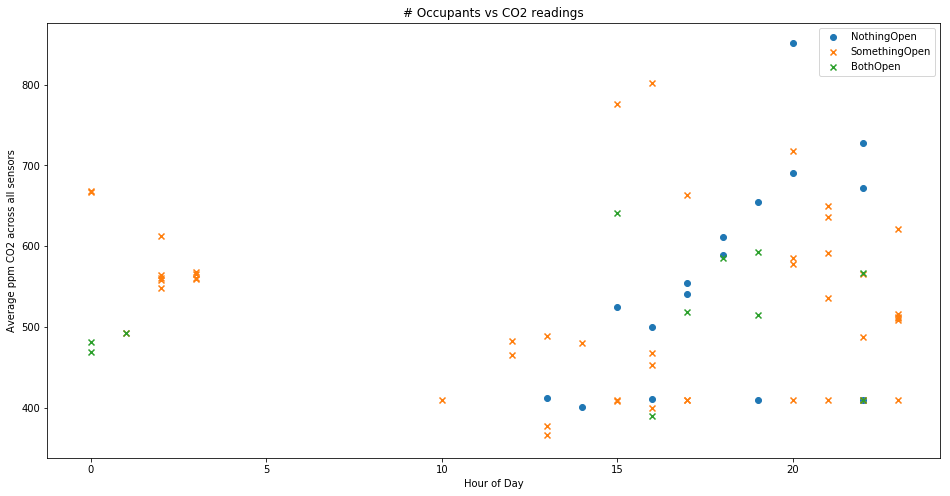

In [28]:
# Investigating the correlation of mean_ppm and window state
NothingOpen = openAperature[['rome_hour', '_mean']].loc[openAperature['Something Open'] == 0]
SomethingOpen = openAperature[['rome_hour', '_mean']].loc[openAperature['Something Open'] == 1]
BothOpen = openAperature[['rome_hour', '_mean']].loc[openAperature['Something Open'] == 2]

plt.scatter(x=NothingOpen['rome_hour'], y=NothingOpen['_mean'], marker='o', label='NothingOpen')
plt.scatter(x=SomethingOpen['rome_hour'], y=SomethingOpen['_mean'], marker='x', label='SomethingOpen')
plt.scatter(x=BothOpen['rome_hour'], y=BothOpen['_mean'], marker='x', label='BothOpen')

plt.xlabel('Hour of Day')
plt.ylabel('Average ppm CO2 across all sensors')
plt.legend(loc='upper right')
plt.title('# Occupants vs CO2 readings')
plt.show()

In [29]:
finalDataSet = openAperature[['rome_hour', 'occupied','# Occupants','Something Open','Window Open','Door Open','1','2','3','4','_mean']]
finalDataSet.head()

,rome_hour,occupied,# Occupants,Something Open,Window Open,Door Open,1,2,3,4,_mean
1510688160,20,1,4,1,0,1,612.375000,619.333333,516.875000,564.958333,578.385417
1510699500,23,1,4,1,0,1,531.555556,574.916667,450.500000,485.478261,510.612621
1510704600,1,1,1,1,0,1,531.555556,520.083333,437.250000,481.500000,492.597222
1510761660,17,1,3,1,0,1,434.200000,325.454545,425.909091,453.090909,409.663636
1510763820,17,1,3,1,1,0,434.200000,325.454545,425.909091,453.090909,409.663636


In [30]:
# finalDataSet.to_csv('11dimensionalCO2Data.csv')

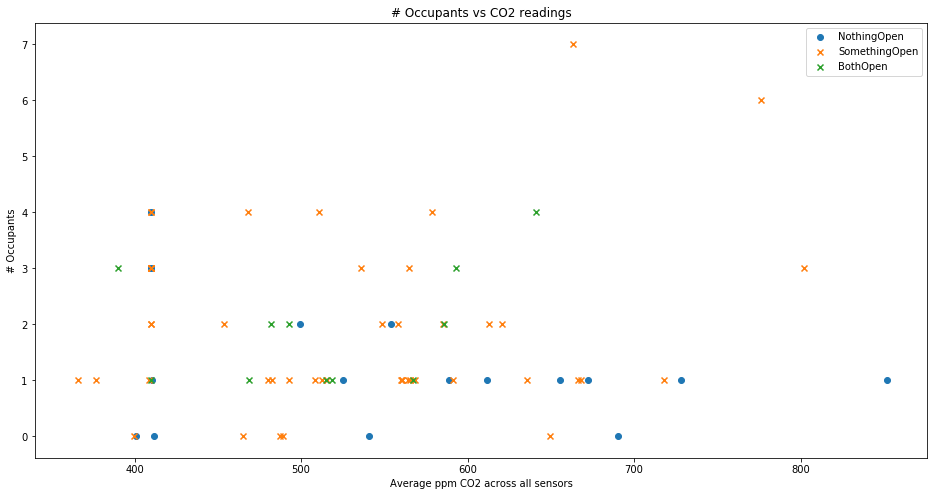

In [31]:
# Investigating the correlation of mean_ppm and window state
NothingOpen = openAperature[['rome_hour', '_mean', '# Occupants']].loc[openAperature['Something Open'] == 0]
SomethingOpen = openAperature[['rome_hour', '_mean', '# Occupants']].loc[openAperature['Something Open'] == 1]
BothOpen = openAperature[['rome_hour', '_mean', '# Occupants']].loc[openAperature['Something Open'] == 2]

plt.scatter(x=NothingOpen['_mean'], y=NothingOpen['# Occupants'], marker='o', label='NothingOpen')
plt.scatter(x=SomethingOpen['_mean'], y=SomethingOpen['# Occupants'], marker='x', label='SomethingOpen')
plt.scatter(x=BothOpen['_mean'], y=BothOpen['# Occupants'], marker='x', label='BothOpen')

plt.xlabel('Average ppm CO2 across all sensors')
plt.ylabel('# Occupants')
plt.legend(loc='upper right')
plt.title('# Occupants vs CO2 readings')
plt.show()

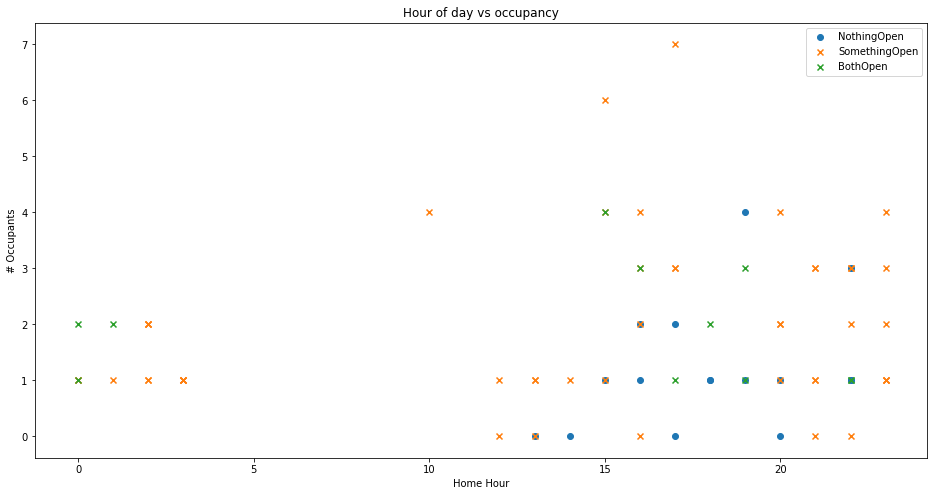

In [32]:
# Investigating the correlation of mean_ppm and window state
NothingOpen = openAperature[['rome_hour', '_mean', '# Occupants']].loc[openAperature['Something Open'] == 0]
SomethingOpen = openAperature[['rome_hour', '_mean', '# Occupants']].loc[openAperature['Something Open'] == 1]
BothOpen = openAperature[['rome_hour', '_mean', '# Occupants']].loc[openAperature['Something Open'] == 2]

plt.scatter(x=NothingOpen['rome_hour'], y=NothingOpen['# Occupants'], marker='o', label='NothingOpen')
plt.scatter(x=SomethingOpen['rome_hour'], y=SomethingOpen['# Occupants'], marker='x', label='SomethingOpen')
plt.scatter(x=BothOpen['rome_hour'], y=BothOpen['# Occupants'], marker='x', label='BothOpen')

plt.xlabel('Home Hour')
plt.ylabel('# Occupants')
plt.legend(loc='upper right')
plt.title('Hour of day vs occupancy')
plt.show()

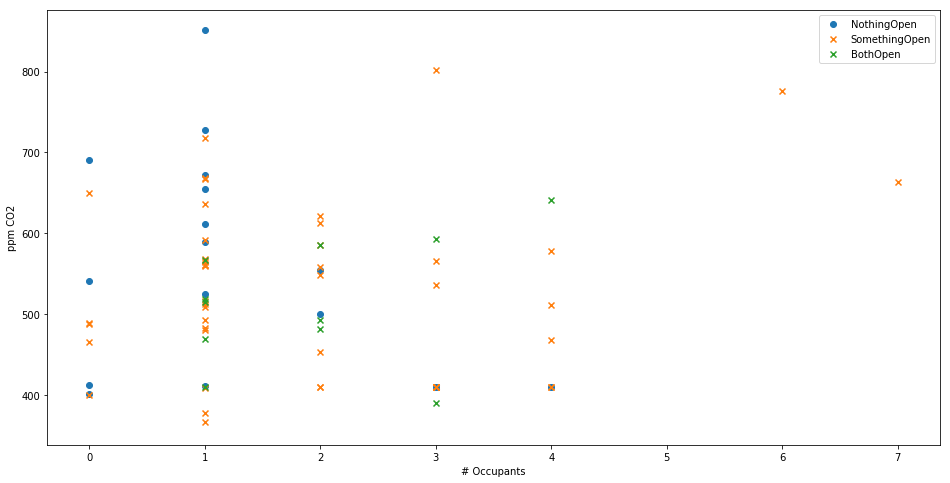

In [33]:
# Investigating the correlation of mean_ppm and window state
NothingOpen = openAperature[['rome_hour', '_mean', '# Occupants']].loc[openAperature['Something Open'] == 0]
SomethingOpen = openAperature[['rome_hour', '_mean', '# Occupants']].loc[openAperature['Something Open'] == 1]
BothOpen = openAperature[['rome_hour', '_mean', '# Occupants']].loc[openAperature['Something Open'] == 2]

plt.scatter(x=NothingOpen['# Occupants'], y=NothingOpen['_mean'], marker='o', label='NothingOpen')
plt.scatter(x=SomethingOpen['# Occupants'], y=SomethingOpen['_mean'], marker='x', label='SomethingOpen')
plt.scatter(x=BothOpen['# Occupants'], y=BothOpen['_mean'], marker='x', label='BothOpen')

plt.xlabel('# Occupants')
plt.ylabel('ppm CO2')
plt.legend(loc='upper right')
plt.show()

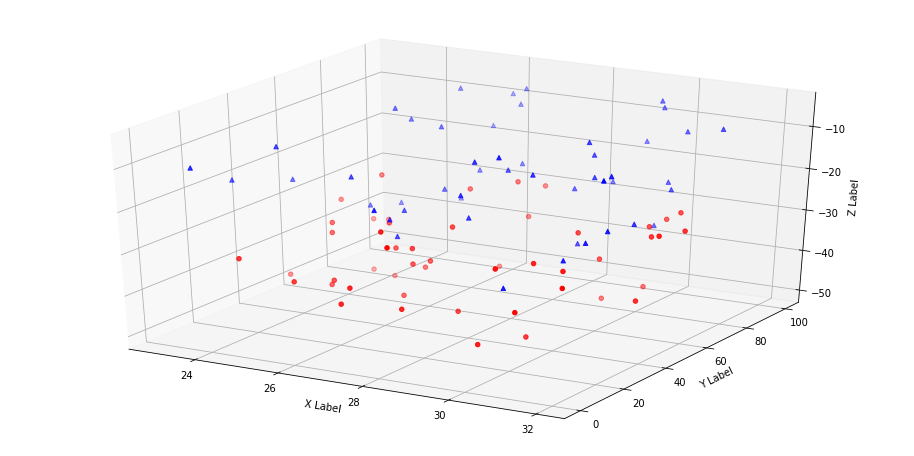

In [34]:
'''
==============
3D scatterplot
==============

Demonstration of a basic scatterplot in 3D.
'''

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 50

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

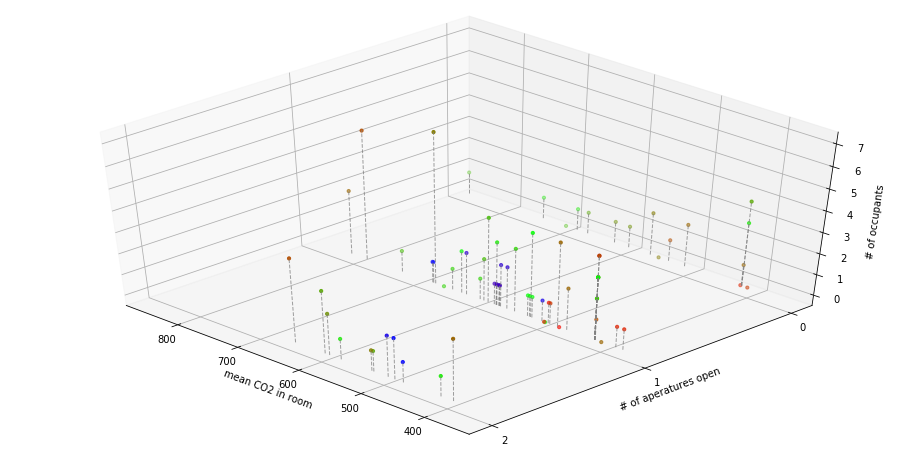

In [35]:
'''
==============
3D scatterplot
==============

Demonstration of a basic scatterplot in 3D.
'''

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


X = '_mean'
Y = 'Something Open'
Z = '# Occupants'
_color = 'rome_hour'

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = finalDataSet.shape[0]

minOcc = finalDataSet[_color].min()
maxOcc = finalDataSet[_color].max()

cmap = matplotlib.cm.get_cmap('brg') #RdYlBu
c = []
for i in finalDataSet[_color]:
    c.append(cmap((i/maxOcc)))
    
for x,y,z in finalDataSet[[X,Y,Z]].as_matrix():
    ax.plot([x, x], [y,y], [0,z], c='grey',linestyle='--', linewidth=1, alpha=.75)
         
xs = finalDataSet[X]
ys = finalDataSet[Y]
ax.set_yticks([0,1,2])
# ax.set_yticklabels(tuple(predictions.index))
zs = finalDataSet[Z]

ax.scatter(xs, ys, zs, c=c, marker='o', s=10 )

ax.set_xlabel('mean CO2 in room')
ax.set_ylabel('# of aperatures open')
ax.set_zlabel('# of occupants')

ax.view_init(45, 90+45)
plt.show()